A raspberry pi project, inspired by [tjaap](https://www.instructables.com/Literary-Clock-Made-From-E-reader/). This python notebook is looking at the basics - how to get the data, parse it, display a quote, then moves on to create a repo and put the code onto the actual hardware.

The primary source for quotes is the [guardian's user provided list](https://www.theguardian.com/books/table/2011/apr/21/literary-clock). This list is incomplete, and the guardian put up a bigger list in 2014 as a gsheet but thats no longer avaiable, so I found a more complete quotes list on [github](https://github.com/JohannesNE/literature-clock/tree/master).

First up, making a list of times to check for missing times:

In [22]:
# | echo: false
import os
import re
import sys
import gzip
from pathlib import Path
import json
import requests
import random
import time  # https://docs.python.org/3/library/time.html
from datetime import datetime, timezone, timedelta

from dataclasses import dataclass
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from openai import OpenAI

In [3]:
# a list containiner all 1,440 times
times = [f"{hour:02}:{minute:02}" for hour in range(24) for minute in range(60)]
assert len(times) == 60 * 24  # check for all 1,440 clock times

# check it looks good
print(times[130:140])
print(times[55:65])

['02:10', '02:11', '02:12', '02:13', '02:14', '02:15', '02:16', '02:17', '02:18', '02:19']
['00:55', '00:56', '00:57', '00:58', '00:59', '01:00', '01:01', '01:02', '01:03', '01:04']


## The literary quotes

I initial looked at the list of quotes on the guardian website from 2011, but that was really incomplete, so after some internet kungfu I moved on to a better [list of quotes maintained here](https://github.com/JohannesNE/literature-clock).

That project already implements a literary clock, but ignoring that to make my own, here goes:

In [5]:
url = "https://raw.githubusercontent.com/JohannesNE/literature-clock/master/litclock_annotated.csv"

df = pd.read_csv(
    url, sep="|", names=["time", "annot", "quote", "title", "author", "nsfw"]
)

df.sample(4)

,time,annot,quote,title,author,nsfw
211,01:23,1:23 a.m.,"Croydon Central was declared at 1:23 a.m., wit...",This Was a Man,Jeffrey Archer,sfw
1098,08:05,five-past eight,"Well, it’s five-past eight now, I said to Drak...",Eight Hours from England,Anthony Quayle,unknown
641,04:56,just before five,"Trying to identify the key facts, Ethan was su...",The Infinite Day,Chris Walley,sfw
1807,11:56,11:56 a.m.,"16th December 1985, 11:56 a.m.<br/>[UNIT 4B, K...",The Book of Lies,Mary Horlock,sfw


Some basic data checks:

18 time values missing: ['06:07', '06:18', '08:21', '10:28', '11:46', '12:31', '13:36', '13:46', '13:47', '13:48', '13:49', '13:50', '13:51', '13:52', '16:31', '16:32', '18:44', '20:44']

684 times have exactly 1 quote, 738 times have more than 1 quote.


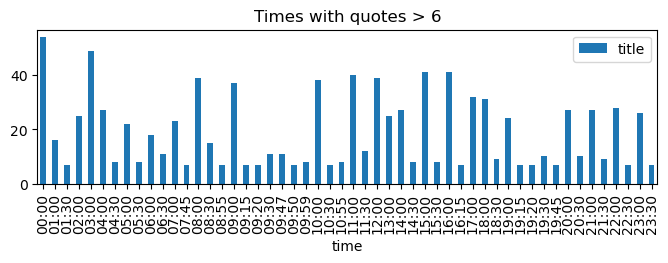

In [6]:
missing_times = [time for time in times if time not in df.time.values]
print(f"{len(missing_times)} time values missing: {missing_times}")

single_quote = sum(df.groupby("time").count().title == 1)
multiple_quotes = sum(df.groupby("time").count().title > 1)

print(
    f"\n{single_quote} times have exactly 1 quote, {multiple_quotes} times have more than 1 quote."
)

ax = (
    df[["time", "title"]]
    .groupby("time")
    .count()[df.groupby("time").count().title > 6]
    .plot.bar(title="Times with quotes > 6", figsize=(8, 2))
)

So we now have a dataframe full of quotes. I'll deal with the 21 missing quotes later.

The gthub repo produced a folder full of json files, one for each time stamp, so I could just re-use that, but whats the fun of that. 

### Spliting up quotes

Ideally, we want the current time in the quote highlighted. The csv file has a col `annot` which is the time part of the quote string. Initially I tried to use regex to split the string, but since the time is in so many different formats it has to be done manually, hence the `annot` col.

The time can contain special characters like `[]` so [re.escape](https://docs.python.org/3/library/re.html?highlight=escape#re.escape) fixes that. I had to use re.split instead of str.split here as only re.split has a ignorecase feature.

In [7]:
def split_quote(row):
    """adds a prefix and suffix to the quote."""
    prefix, suffix = re.split(
        re.escape(row.annot), row.quote, maxsplit=1, flags=re.IGNORECASE
    )
    row["prefix"] = prefix
    row["suffix"] = suffix
    return row


df = df.apply(split_quote, axis=1)
df.sample(3)

,time,annot,quote,title,author,nsfw,prefix,suffix
1659,11:00,eleven o’clock,Around eleven o’clock the door was unlocked. I...,Cloud Atlas,David Mitchell,unknown,Around,the door was unlocked. I readied myself to re...
470,03:17,3:17,"The two of us sat there, listening—Boris more ...",The Goldfinch,Donna Tartt,nsfw,"The two of us sat there, listening—Boris more ...",in the morning.
393,03:00,three in the morning,The scent and smoke and sweat of a casino are ...,Casino Royale,Ian Fleming,unknown,The scent and smoke and sweat of a casino are ...,.


I can now display the quote with the time highlighted, an example below in markdown format:

In [8]:
row = df.iloc[100]
f"{row.prefix}**{row.annot}**{row.suffix}"

"A Mr. Dutta from King's Cross called and told me you were on your way. He said you wanted to see the arrival of yesterday's **12.26 am**. It'll take me a few minutes to cue up the footage. Our regular security bloke isn't here today; he's up before Haringey Magistrates' Court for gross indecency outside the headquarters of the Dagenham Girl Pipers."

### Saving quotes to disk

First up, saving a single json object containing all the quotes, which is easy to use:

In [14]:
# returns a string representing the json
quotes_json = df.groupby("time").agg(list).to_json(orient="index")

# writes the json to disk, ommiting the quotes col to save on disk space
df.drop(columns=["quote"]).groupby("time").agg(list).to_json(
    "quotes.json", orient="index", compression=None
)

# read the quotes from disk
with open("quotes.json", "r") as f:
    quotes = json.load(f)

print(f"{len(quotes):,} keys which look like: {list(quotes.keys())[40:44]}")
quotes["01:40"]

1,422 keys which look like: ['00:40', '00:41', '00:42', '00:43']


{'annot': ['one-forty am'],
 'title': ['Bones to Ashes'],
 'author': ['Kathy Reichs'],
 'nsfw': ['unknown'],
 'prefix': ['March twelfth, '],
 'suffix': [', she leaves a group of drinking buddies to catch a bus home. She never makes it.']}

This json/dict has the time in HH:MM as the key, which brings up a dict of lists:

In [15]:
quotes["00:02"]

{'annot': ['two minutes past twelve', 'two minutes past midnight'],
 'title': ['Billy Summers', 'Night of the Krait'],
 'author': ['Stephen King', 'Shashi Warrier'],
 'nsfw': ['unknown', 'unknown'],
 'prefix': ['At ', ''],
 'suffix': [' the door opens and two men come into the lobby. One is tall with black hair combed in a 50’s pompadour. The other is short and bespectacled. Both are wearing suits.',
  '. With me in the lead the fourteen other men of Teams Yellow, White and Red moved out of the clearing and separated for points along the wall where they would cross over into the grounds.']}

### Save each hour as a seperate file

I'm using a raspberry pi pico w, it doesn't have enough memory to contain the ~2k quotes. So I'm going to write a json file for every hour, and open and close each file as needed.

I'm keeping only the columns needed to save on diskspace:

In [16]:
df.sample(1)

,time,annot,quote,title,author,nsfw,prefix,suffix
2141,14:25,2:25,"There was a moment today, at 2:25, when study ...",Staggerford,Jon Hassler,unknown,"There was a moment today, at",", when study hall came suddenly to life. Heads..."


In [18]:
# saving 24 quotes file as json to quotes folder

for hour in range(24):
    # Format the hour to match the 'HH' format
    formatted_hour = f"{hour:02d}"
    # Filter the DataFrame for rows where the 'time' starts with the formatted hour
    filtered_df = df[df["time"].str.startswith(formatted_hour)]

    # writes the json to disk, ommiting the quotes col to save on disk space
    # manually change compression to None to write json
    filtered_df.drop(columns=["quote"]).groupby("time").agg(list).to_json(
        f"quotes/{formatted_hour}.json", orient="index", compression=None
    )

# read the sameple quote hour from disk
with open("quotes/03.json", "r") as f:
    quotes_03 = json.load(f)

# Checking the total size of the many quote files

for folder in ("quotes", "quotes_gz"):
    files = [f for f in os.listdir(folder)]
    quotes_size = sum([os.path.getsize(f"{folder}/{f}") for f in files]) / 10**3
    print(f"{len(files):,} {folder} files total {quotes_size:.2f}kb")

25 quotes files total 1100.42kb
24 quotes_gz files total 488.64kb


Now I want to take the json files in the `quotes` folder and gzip them into the `quotes_gzip` folder.

In [30]:
f.name + ".gz"

'23.json.gz'

In [40]:
# Directory containing the original .json files
source_dir = Path("quotes")

# Directory where the .gz files will be saved
target_dir = Path("quotes_gz")
target_dir.mkdir(parents=True, exist_ok=True)  # Ensure target directory exists

for f in source_dir.glob("*.json"):
    gz_file = target_dir / (f.name + ".gz")
    with f.open("rb") as original_file, gzip.open(gz_file, "wb") as gz_f:
        gz_f.writelines(original_file)
    print(f"Compressed {f} to {gz_file}")

Compressed quotes/20.json to quotes_gz/20.json.gz
Compressed quotes/16.json to quotes_gz/16.json.gz
Compressed quotes/00.json to quotes_gz/00.json.gz
Compressed quotes/01.json to quotes_gz/01.json.gz
Compressed quotes/17.json to quotes_gz/17.json.gz
Compressed quotes/21.json to quotes_gz/21.json.gz
Compressed quotes/10.json to quotes_gz/10.json.gz
Compressed quotes/06.json to quotes_gz/06.json.gz
Compressed quotes/07.json to quotes_gz/07.json.gz
Compressed quotes/11.json to quotes_gz/11.json.gz
Compressed quotes/04.json to quotes_gz/04.json.gz
Compressed quotes/12.json to quotes_gz/12.json.gz
Compressed quotes/08.json to quotes_gz/08.json.gz
Compressed quotes/09.json to quotes_gz/09.json.gz
Compressed quotes/13.json to quotes_gz/13.json.gz
Compressed quotes/05.json to quotes_gz/05.json.gz
Compressed quotes/22.json to quotes_gz/22.json.gz
Compressed quotes/18.json to quotes_gz/18.json.gz
Compressed quotes/02.json to quotes_gz/02.json.gz
Compressed quotes/14.json to quotes_gz/14.json.gz


In [20]:
compression = {"method": "gzip", "compresslevel": 1, "mtime": 1}

for hour in range(24):
    # Format the hour to match the 'HH' format
    formatted_hour = f"{hour:02d}"
    # Filter the DataFrame for rows where the 'time' starts with the formatted hour
    filtered_df = df[df["time"].str.startswith(formatted_hour)]

    # writes the json to disk, ommiting the quotes col to save on disk space
    # manually change compression to None to write json
    filtered_df.drop(columns=["quote"]).groupby("time").agg(list).to_json(
        f"quotes_gz/{formatted_hour}.json.gz", orient="index", compression=compression
    )

# read the sameple quote hour from disk
with open("quotes/03.json", "r") as f:
    quotes_03 = json.load(f)

with gzip.open("quotes_gz/03.json.gz", "rt") as f:
    quotes_03gz = json.load(f)

# Checking the total size of the many quote files

for folder in ("quotes", "quotes_gz"):
    files = [
        f for f in os.listdir(folder) if (f.endswith(".json") or f.endswith(".gz"))
    ]
    quotes_size = sum([os.path.getsize(f"{folder}/{f}") for f in files]) / 10**3
    print(f"{len(files):,} {folder} files total {quotes_size:.2f}kb")

# check the gz files look ok
quotes_03 == quotes_03gz

24 quotes files total 1094.28kb
24 quotes_gz files total 488.64kb


True

In [21]:
quotes_03["03:21"]

{'annot': ['3:21', '3:21', 'twenty-one minutes past three'],
 'title': ['Honor Among Thieves',
  'The Sins of the Father',
  'The Toilers of the Sea'],
 'author': ['Jeffrey Archer', 'Jeffrey Archer', 'Victor Hugo'],
 'nsfw': ['sfw', 'sfw', 'unknown'],
 'prefix': ['He didn’t bother to shower or shave, and dressed quickly in the clothes he had worn the previous day. He left his apartment in Queens at ',
  'She glanced again at the bedside clock: ',
  'Next, he remembered that the morrow of Christmas would be the twenty-seventh day of the moon, and that consequently high water would be at '],
 'suffix': [' and drove himself into Manhattan, leaving his car outside the front of the precinct a few minutes before four.',
  '. She got out of bed, put on a dressing gown, sat down at the little table and filled several sheets of hotel stationery with notes in preparation for her meeting with Sefton Jelks. It felt like prepping for an exam.',
  ', the half-ebb at a quarter past seven, low water a

I can compress these to save further on space, which I'll get to later if needed. Its nice to have a human readable json string rather than a binary object on the pico for future poking around.

## Get current time and display quote

Micropython has a [time](https://docs.micropython.org/en/latest/library/time.html) module, which is a subset of the [built in python time library](https://docs.python.org/3/library/time.html). The pi's clock needs to be synced on boot with a timeserver, leaving that for the future...

Right now, I get the current time, than open the json file for that timestamp, select a random quote from it and return it.

In [78]:
t = datetime.now()
t

datetime.datetime(2024, 4, 21, 22, 34, 52, 967704)

In [80]:
def get_time():
    """returns current time in 00:00 format"""
    try:
        t = time.localtime()
    except:
        t = datetime.now()

    # t = (2024, 4, 20, 2, 48, 6, 5, 111)

    return f"{t[3]:02}:{t[4]:02}"


get_time()[:2]

'22'

In [98]:
def get_quote(time_str=None):
    """returns a dict containing a single quote for a given time"""
    if time_str is None:
        time_str = get_time()

    hour = time_str[:2]
    file_hour = None

    # load file
    if file_hour != hour:
        with open(f"quotes/{hour}.json", "r") as f:
            quotes = json.load(f)
            file_hour = hour

    try:
        quote = quotes[time_str]
    except:
        quote_fail = {
            "annot": time_str,
            "title": "Add this quote",
            "author": "",
            "nsfw": "duh",
            "prefix": "This time, at ",
            "suffix": ", needs a quote",
        }

    i = random.randint(0, len(quote["title"]) - 1)
    print(f"returning quote for {time_str} from {len(quote['title'])} total quotes.")
    return {key: quote[key][i] for key in quote.keys()}


quote = get_quote()
print(f"quote dict keys: {quote.keys()}")
print(f"\n{quote['prefix']}**{quote['annot']}**{quote['suffix']}")
print(f"{quote['title']} by {quote['author']}")

returning quote for 22:47 from 1 total quotes.
quote dict keys: dict_keys(['annot', 'title', 'author', 'nsfw', 'prefix', 'suffix'])

On my screen the remaining theatregoers slowly drift away and when the timestamp clicks over to **10.47 pm** there is no one left.
The Dark Lake by Sarah Bailey


That seems to be working well, so now I should be able to assemble the pieces and display this on a raspberry pico display.

In the pico, the above code should be in the main loop, so the read in json file for the hour stays in memory.

# Raspberry Pi Pico

Allright, now that I have the basics ready to go, here goes putting this on a pi pico. First up, we need a github repo. 

## Web quote clock TODO

Now that I have all the quotes sorted, another mini project - making a web version like [ticktockquotes.com](https://github.com/0plus1/ticktockquotes.com).

## Misc

Things not needed anymore, left in case they are useful in the future.

### Guardian quotes from 2011

Guardian clock quotes from 2011, left below as a pandas exercise in fetching a table from a html page and some basic transformations to be able to use it.

In [677]:
clock_url = "https://www.theguardian.com/books/table/2011/apr/21/literary-clock"

df_quotes = (
    pd.read_html(clock_url)[0]  # get first table
    .rename(
        columns={
            "Time of quote": "time",
            "Quote": "quote",
            "Title of book": "title",
            "Author": "author",
        }
    )
    .sort_values(by="time")
    .drop(columns=["Your username"])  # no need for this col
    .dropna(subset=["quote"])  # drop blank rows at end
)

# fix some wonky time strings
df_quotes.time = df_quotes.time.str.replace(".", ":")

print(f"{df_quotes.shape} quotes, so missing a lot!")
df_quotes.sample(2)

(935, 4) quotes, so missing a lot!


,time,quote,title,author
204,07:10:00h,A search in Bradshaw informed me that a train ...,The 39 Steps,John Buchan
409,11:15:00h,The first time I saw them it was around eleven...,Where I'm Calling From,Raymond Carver


There is a 2014 Guardlian list, but looks like that was a google sheet which they have now taken down.